**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx/cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m20-improved.csv'
path_dump_improved = '../output/m20-improved-4.csv' # output solution

num_cpu_cores = 6
#time_limit = -1 # unlimited
time_limit = 4*24*60*60  # in s

occupancy_diff = 200  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_pref_cost_lower = 62867
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 5554
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69677.42974104256
Preference cost: 64123
Accounting cost: 5554.42974104256


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 255 253 271 296 300 297 273 262 258 273 296
 290 274 247 223 228 256 283 300 292 273 257 244 246 275 275 256 224 195
 167 192 227 251 236 206 176 160 125 294 276 251 219 188 156 125 282 260
 231 195 160 127 125 263 238 205 163 125 125 125 246 219 183 139 125 125
 125 225 206 175 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

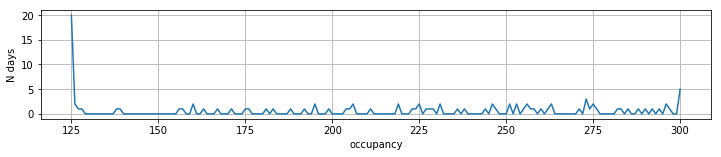

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

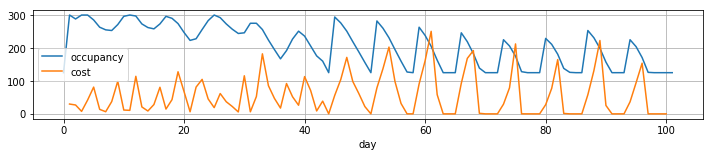

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]], dtype=int32)

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]], dtype=int32)

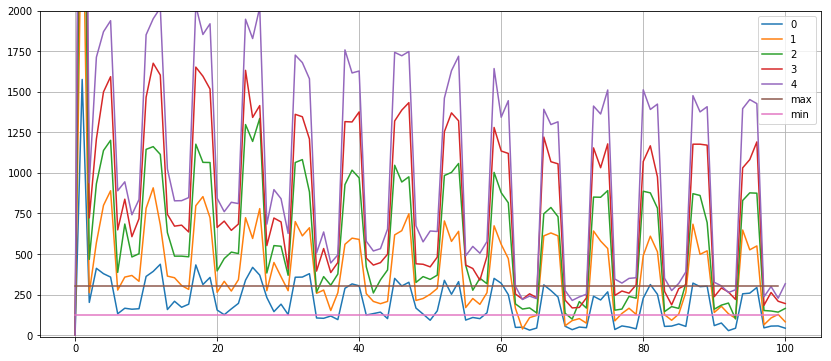

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

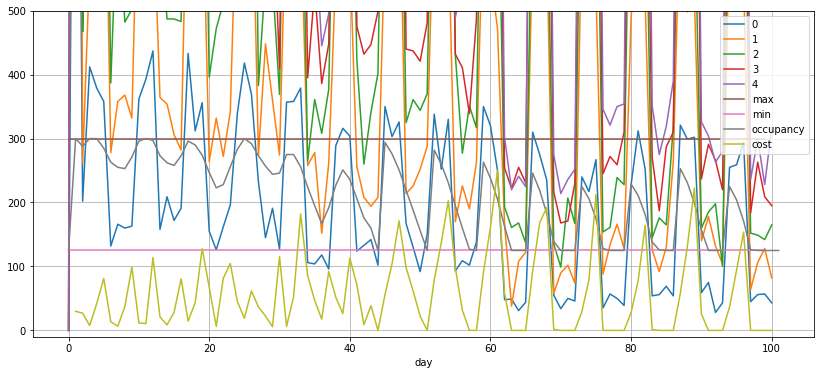

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

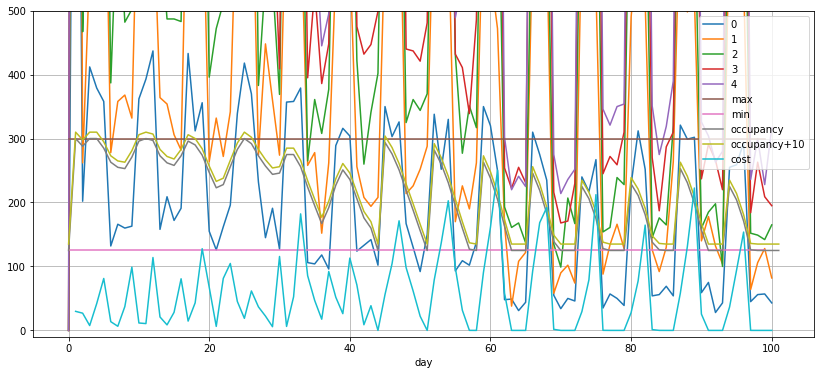

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = [N_max_people]
    elif day == N_days:
        search_occupancy[day] = [N_min_people]
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 [300]
2 range(125, 301)
3 range(125, 301)
4 range(125, 301)
5 range(125, 301)
6 range(125, 301)
7 range(125, 301)
8 range(125, 301)
9 range(125, 301)
10 range(125, 301)
11 range(125, 301)
12 range(125, 301)
13 range(125, 301)
14 range(125, 301)
15 range(125, 301)
16 range(125, 301)
17 range(125, 301)
18 range(125, 301)
19 range(125, 301)
20 range(125, 301)
21 range(125, 301)
22 range(125, 301)
23 range(125, 301)
24 range(125, 301)
25 range(125, 301)
26 range(125, 301)
27 range(125, 301)
28 range(125, 301)
29 range(125, 301)
30 range(125, 301)
31 range(125, 301)
32 range(125, 301)
33 range(125, 301)
34 range(125, 301)
35 range(125, 301)
36 range(125, 301)
37 range(125, 301)
38 range(125, 301)
39 range(125, 301)
40 range(125, 301)
41 range(125, 301)
42 range(125, 301)
43 range(125, 301)
44 range(125, 136)
45 range(125, 301)
46 range(125, 301)
47 range(125, 301)
48 range(125, 301)
49 range(125, 301)
50 range(125, 301)
51 range(125, 136)
52 range(125, 301)
53 range(125, 301)
54 range(125

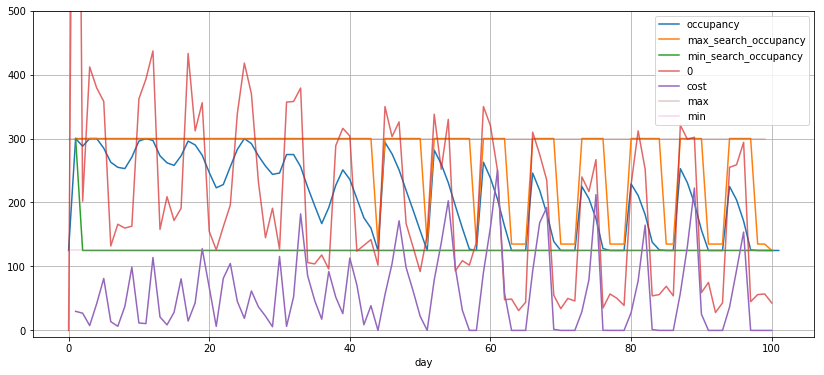

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(occupancy, label='occupancy')
plt.plot(pd.Series({d: max(v) for d, v in search_occupancy.items()}), label='max_search_occupancy')
plt.plot(pd.Series({d: min(v) for d, v in search_occupancy.items()}), label='min_search_occupancy')
for i in range(1):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i), alpha=0.7)
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.plot([N_max_people]*N_days, label='max', alpha=0.3)
plt.plot([N_min_people]*N_days, label='min', alpha=0.3)
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

In [26]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [27]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

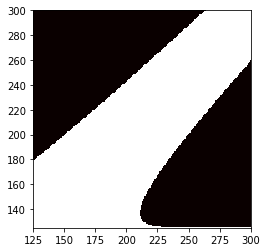

In [28]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [29]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 7


In [30]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  77, ..., 227, 254, 354],
       ...,
       [  0,  50, 104, ..., 254, 308, 408],
       [  0,  50,  95, ..., 245, 290, 390],
       [  0,  50,  86, ..., 236, 272, 372]])

## DOCplex model

In [31]:
from docplex.mp.model import Model

In [32]:
solver = Model('')

In [33]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 6
Num treads: threads:int(6)
Set time limit: None


In [34]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [35]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [36]:
len(assignment_matrix)

35000

In [37]:
possible_family_sizes = np.unique(n_people)

In [38]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [39]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [40]:
search_occupancy[N_days]

[125]

In [41]:
len(occupancy_matrix)

1074836

## Constraints

### constraint 1: each family only take one day (choice)

In [42]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [43]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [44]:
# constraint 2: each day can only have 125-300 people

In [45]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

7

In [46]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [47]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [48]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [49]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [50]:
# constraint 3: unpreferred day family count conservation for each family size

In [51]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [52]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [53]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [54]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [55]:
# next day occupancy consistency
solver.add_constraints_([
    occupancy_counts[day + 1] == solver.sum([
        occupancy_matrix[day, o, o_next] * o_next 
        for o in search_occupancy[day]
        for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next]            
    ])
    for day in days if day < N_days
])

# redudant constraints
if redundant_occupancy_constraints:
    for day in days:
        if day + 1 < N_days:
            solver.add_constraints_([
                solver.sum([
                    occupancy_matrix[day, o_other, o] 
                    for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                ]) == solver.sum([
                    occupancy_matrix[day + 1, o, o_other]
                    for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                ])
                for o in search_occupancy[day + 1]
            ])
    solver.add_constraints_([
        solver.sum([
            occupancy_matrix[N_days - 1, o_other, o] 
            for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
        ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        for o in search_occupancy[N_days]
    ])

### Preference cost

In [56]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [57]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        print('Limit preference cost in range')
        solver.add_range(
            target_pref_cost - target_pref_cost_error,
            family_pref_cost,
            target_pref_cost + target_pref_cost_error
        )
    else:
        print('Limit preference cost exactly')
        solver.add_constraint_(family_pref_cost == target_pref_cost)
elif target_pref_cost_lower > 0:
    print('Lower bound preference cost')
    solver.add_constraint_(family_pref_cost >= target_pref_cost_lower)

Lower bound preference cost


### Accounting cost

In [58]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [59]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

Lower bound accounting cost


In [60]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [61]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [62]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [63]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [64]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [65]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [66]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 1109836 ( 1109836 , 0 )
N of constraints: 19516
Time limit: 345600.0


In [ ]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 6
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               345600
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.23 sec. (176.43 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69677.4297.
Presolve has eliminated 2203 rows and 180929 columns...
Tried aggregator 2 times.
MIP Presolve eliminated 2203 rows and 180929 columns.
MIP Presolve modified 48203 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 17310 rows, 929006 columns, and 5522048 nonzeros.
Reduced MIP has 928908 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 7.91 sec. (11073.84 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 17310 rows, 929006 columns, and 5522048 nonzeros.
Reduced MIP has 928908 binar

     90    58    68591.6919   549    69670.7533    68422.1308   300084    1.79%
     91    59    68591.6982   554    69670.7533    68422.1308   300139    1.79%
     92    60    68592.5346   531    69670.7533    68422.1308   300475    1.79%
Elapsed time = 5130.08 sec. (6457750.35 ticks, tree = 14.92 MB, solutions = 3)
     94    45    68570.3488   561    69670.7533    68422.1308   289119    1.79%
     95    61    68592.6158   515    69670.7533    68422.1308   300611    1.79%
     98    62    68592.6831   513    69670.7533    68422.1308   300732    1.79%
    100    63    68592.7002   507    69670.7533    68422.1308   300806    1.79%
    104    84    68660.7229   500    69670.7533    68422.1308   310583    1.79%
    105    89    68549.6082   578    69670.7533    68422.1308   315480    1.79%
    108    86    68570.4243   550    69670.7533    68422.1308   311665    1.79%
    110    86    68661.3410   469    69670.7533    68422.1308   310917    1.79%
    112    90    68549.7295   586    6967

   1196   782    69200.3331   152    69670.7533    68422.1308   452425    1.79%
   1243   803    69223.7046   161    69670.7533    68422.1308   452811    1.79%
   1303   799    69317.0771   114    69670.7533    68422.1308   440381    1.79%
   1361   879    69274.6926   128    69670.7533    68422.1308   461189    1.79%
   1420  1028    69400.8245   115    69670.7533    68422.1308   477768    1.79%
   1483  1050    69451.3244   124    69670.7533    68422.1308   478284    1.79%
   1548  1076    69471.9541   118    69670.7533    68422.1308   478929    1.79%
   1596  1098    69433.9461   102    69670.7533    68422.1308   479344    1.79%
   1659   935    69327.8471   145    69670.7533    68422.1308   455832    1.79%
   1689  1220    69383.1431   110    69670.7533    68422.1308   483026    1.79%
Elapsed time = 5735.56 sec. (6807230.94 ticks, tree = 558.92 MB, solutions = 3)
   1738  1160    69556.3711   129    69670.7533    68422.1308   480529    1.79%
   1782  1183    69569.4659   125    696

   2123    11    69055.1448   623    69670.7533    68716.5326   834729    1.37%
   2125    20    68738.2499   673    69670.7533    68716.5326   837050    1.37%
Elapsed time = 9652.43 sec. (12056411.84 ticks, tree = 4.69 MB, solutions = 3)
   2127    21    68740.9936   640    69670.7533    68716.5326   837734    1.37%
   2130    22    68741.9409   653    69670.7533    68716.5326   838082    1.37%
   2132     5    68755.1482   772    69670.7533    68716.5326   828990    1.37%
   2133    13    69061.8740   587    69670.7533    68716.5326   835853    1.37%
   2135    23    68744.4102   653    69670.7533    68716.5326   838471    1.37%
   2136    21    68755.2316   768    69670.7533    68716.5616   840466    1.37%
   2138    14    69058.6019   598    69670.7533    68716.5616   836305    1.37%
   2140    25    68746.2193   663    69670.7533    68716.5616   838922    1.37%
   2143    22    68755.4158   751    69670.7533    68716.5616   840548    1.37%
   2145    32    68725.6630   934    6967

   2337   190    69325.1991   553    69670.7533    68718.9175   935129    1.37%
   2339   188    68786.7802   577    69670.7533    68718.9175   930309    1.37%
   2341   166    68914.8038   781    69670.7533    68718.9175   921710    1.37%
   2342   189    68789.2215   560    69670.7533    68718.9175   930721    1.37%
   2343   173    68850.6346   583    69670.7533    68718.9175   930481    1.37%
   2345   220    68766.4504   725    69670.7533    68718.9175   950333    1.37%
   2347   203    68846.7027   522    69670.7533    68718.9175   941961    1.37%
   2349   191    69329.4533   564    69670.7533    68718.9175   936276    1.37%
   2350   192    68795.8332   565    69670.7533    68718.9175   931734    1.37%
Elapsed time = 10759.44 sec. (12741605.38 ticks, tree = 51.28 MB, solutions = 3)
   2351   222    68850.9364   585    69670.7533    68718.9175   956623    1.37%
   2353   193    68797.7782   570    69670.7533    68718.9175   932234    1.37%
   2354   192    69326.1342   517    69

   2661   445    69416.6800   425    69670.7533    68718.9175  1066512    1.37%
   2664   412    68856.7349   419    69670.7533    68718.9175  1045384    1.37%
   2668   401    68873.3058   378    69670.7533    68718.9175  1031213    1.37%
   2670   447    69420.5325   412    69670.7533    68718.9175  1067486    1.37%
   2671   415    68877.6042   517    69670.7533    68718.9175  1055495    1.37%
Elapsed time = 11524.12 sec. (13195866.22 ticks, tree = 145.04 MB, solutions = 3)
   2674   417    68877.6815   549    69670.7533    68718.9175  1055573    1.37%
   2676   405    69346.0934   568    69670.7533    68718.9175  1044383    1.37%
   2680   505    68873.4034   408    69670.7533    68718.9175  1074829    1.37%
   2687   507    68873.4631   404    69670.7533    68718.9175  1074993    1.37%
   2691   474    68818.2655   651    69670.7533    68718.9175  1071206    1.37%
   2697   520    69348.7872   508    69670.7533    68718.9175  1083988    1.37%
   2705   454    69430.2854   391    6

   3081   867    69356.8315   519    69670.7533    68718.9175  1205295    1.37%
Elapsed time = 12278.45 sec. (13645649.15 ticks, tree = 343.96 MB, solutions = 3)
   3086   804    68934.1864   412    69670.7533    68718.9175  1180488    1.37%
   3094   861    69472.3567   396    69670.7533    68718.9175  1197473    1.37%
   3097   833    68890.6754   396    69670.7533    68718.9175  1188185    1.37%
   3100   834    68924.9487   397    69670.7533    68718.9175  1188469    1.37%
   3105   836    68891.1420   409    69670.7533    68718.9175  1188737    1.37%
   3110   806    68937.5305   444    69670.7533    68718.9175  1181883    1.37%
   3118   869    69481.6462   356    69670.7533    68718.9175  1199632    1.37%
   3124   919    68915.1842   223    69670.7533    68718.9175  1212558    1.37%
   3128   871    69482.6523   405    69670.7533    68718.9175  1200354    1.37%
   3133   924    68916.1830   212    69670.7533    68718.9175  1213073    1.37%
Elapsed time = 12367.51 sec. (13697061

   3532  1200    69446.9440   495    69670.7533    68718.9175  1306961    1.37%
   3535  1280    69067.8016   535    69670.7533    68718.9175  1324894    1.37%
   3540  1216    68989.0789   515    69670.7533    68718.9175  1311345    1.37%
   3543  1310    68916.6968   316    69670.7533    68718.9175  1330166    1.37%
   3549  1283    69068.5374   540    69670.7533    68718.9175  1325647    1.37%
   3552  1219    68990.7429   488    69670.7533    68718.9175  1312070    1.37%
   3554  1202    69447.7239   479    69670.7533    68718.9175  1308871    1.37%
   3560  1285    69070.4727   523    69670.7533    68718.9175  1326350    1.37%
Elapsed time = 13164.68 sec. (14173592.41 ticks, tree = 539.30 MB, solutions = 3)
   3566  1314    68916.9823   251    69670.7533    68718.9175  1332044    1.37%
   3569  1252    69319.6124   347    69670.7533    68718.9175  1319685    1.37%
   3576  1287    69073.6890   542    69670.7533    68718.9175  1327160    1.37%
   3582  1288    69074.2603   548    6

   4149  1821    69167.0724   494    69670.7533    68718.9175  1480562    1.37%
   4159  1725    69010.7975   150    69670.7533    68718.9175  1466925    1.37%
   4164  1803    69479.2896   282    69670.7533    68718.9175  1477227    1.37%
   4170  1805    69479.3123   283    69670.7533    68718.9175  1477625    1.37%
Elapsed time = 13869.61 sec. (14583951.92 ticks, tree = 779.74 MB, solutions = 3)
   4177  1831    68923.8330   434    69670.7533    68718.9175  1489360    1.37%
   4184  1731    69038.1069   141    69670.7533    68718.9175  1467867    1.37%
   4187  1833    68924.7691   432    69670.7533    68718.9175  1489697    1.37%
   4192  1735    69043.6825   136    69670.7533    68718.9175  1468412    1.37%
   4201  1741    69012.5411   126    69670.7533    68718.9175  1468654    1.37%
   4206  1862    69562.9634   353    69670.7533    68718.9175  1495146    1.37%
   4217  1744    69015.4909   144    69670.7533    68718.9175  1469261    1.37%
   4231  1832    69171.6728   536    6

Elapsed time = 14546.50 sec. (14963280.92 ticks, tree = 1173.33 MB, solutions = 3)
   5201  2620    69209.9654   217    69670.7533    68728.9651  1586241    1.35%
   5206  2628    69175.7558   527    69670.7533    68728.9651  1586328    1.35%
   5212  2138    68834.5042   579    69670.7533    68728.9651  1535183    1.35%
   5216  2793    68834.7567   576    69670.7533    68728.9651  1609659    1.35%
   5219  2663    68943.3530   320    69670.7533    68728.9651  1593765    1.35%
   5226  2629    69227.7960   211    69670.7533    68728.9651  1587421    1.35%
   5234  2799    68835.7081   573    69670.7533    68728.9651  1610055    1.35%
   5241  2804    68836.1205   573    69670.7533    68728.9651  1610161    1.35%
   5244  2633    69177.2360   521    69670.7533    68728.9651  1587956    1.35%
   5248  2635    69177.8104   527    69670.7533    68728.9651  1588543    1.35%
Elapsed time = 14635.38 sec. (15015538.55 ticks, tree = 1178.44 MB, solutions = 3)
   5252  2637    69243.6437   251 

   5666  3206    69390.8508   203    69670.7533    68730.9272  1712379    1.35%
   5670  3290    69407.9228   205    69670.7533    68730.9272  1738542    1.35%
   5675  3237    69206.4514   486    69670.7533    68730.9272  1732252    1.35%
   5681  3297    69381.2540   166    69670.7533    68730.9272  1739336    1.35%
   5686  3300    69400.0191   158    69670.7533    68730.9272  1739798    1.35%
   5691  3238    69207.5542   476    69670.7533    68730.9272  1732847    1.35%
   5697  3307    69384.6566   166    69670.7533    68730.9272  1740768    1.35%
Elapsed time = 15388.40 sec. (15446364.17 ticks, tree = 1491.84 MB, solutions = 3)
   5706  3314    69386.2386   174    69670.7533    68730.9272  1741100    1.35%
   5713  3318    69392.6637   158    69670.7533    68730.9272  1741648    1.35%
   5723  3222    68998.9729   192    69670.7533    68730.9272  1732531    1.35%
   5726  3303    68839.9208   583    69670.7533    68730.9272  1751675    1.35%
   5732  3330    69397.8406   169    

   6223  3749    69103.9888   471    69670.7533    68730.9272  1850708    1.35%
   6227  3652    69099.6230   104    69670.7533    68730.9272  1835826    1.35%
   6232  3655    69110.5426   150    69670.7533    68730.9272  1836142    1.35%
Elapsed time = 16368.50 sec. (15883734.09 ticks, tree = 1656.95 MB, solutions = 3)
   6235  3835    69104.1474   150    69670.7533    68730.9272  1874386    1.35%
   6238  3837    69085.7564   172    69670.7533    68730.9272  1874720    1.35%
   6243  3840    69271.4734   134    69670.7533    68730.9272  1875532    1.35%
   6245  3841    69086.1862   185    69670.7533    68730.9272  1875801    1.35%
   6247  3759    68859.3661   509    69670.7533    68730.9272  1853082    1.35%
   6251  3757    68968.1115   609    69670.7533    68730.9272  1862347    1.35%
   6255  3845    69097.5381   144    69670.7533    68730.9272  1876955    1.35%
   6257  3758    68968.1246   550    69670.7533    68730.9272  1862492    1.35%
   6261  3760    68861.5644   413    

   7355  4939    69050.2982   511    69670.7533    68730.9272  2194115    1.35%
Elapsed time = 23008.23 sec. (20685306.57 ticks, tree = 2254.21 MB, solutions = 3)
Nodefile size = 186.63 MB (75.89 MB after compression)
   7356  4933    69015.5880   491    69670.7533    68730.9272  2193702    1.35%
   7361  4935    69017.4996   408    69670.7533    68730.9272  2194819    1.35%
   7370  4935    68918.1643   320    69670.7533    68730.9272  2193128    1.35%
   7377  4939    69023.9298   449    69670.7533    68730.9272  2196951    1.35%
   7386  4948    69056.3778   474    69670.7533    68730.9272  2197428    1.35%
   7399  4945    68935.0207   316    69670.7533    68730.9272  2196191    1.35%
   7408  4943    68936.7121   350    69670.7533    68730.9272  2197552    1.35%
   7419  4945    68936.7694   274    69670.7533    68730.9272  2198545    1.35%
   7439  4952    68938.7643   289    69670.7533    68730.9272  2198887    1.35%
   7448  4971    68895.3512   423    69670.7533    68730.9272 

   8698  5997    68921.7778   268    69670.7533    68730.9272  2535287    1.35%
   8711  6130    69061.1737   210    69670.7533    68730.9272  2585295    1.35%
   8725  6133    69062.0572   189    69670.7533    68730.9272  2586096    1.35%
   8738  6012    68926.6217   245    69670.7533    68730.9272  2537961    1.35%
Elapsed time = 26412.08 sec. (22167451.50 ticks, tree = 2752.55 MB, solutions = 3)
Nodefile size = 653.50 MB (265.82 MB after compression)
   8751  6019    68927.5008   270    69670.7533    68730.9272  2538607    1.35%
   8767  6028    68929.5826   264    69670.7533    68730.9272  2539416    1.35%
   8783  6141    69063.1363   182    69670.7533    68730.9272  2588521    1.35%
   8802  6178    69159.7330   419    69670.7533    68730.9272  2598754    1.35%
   8820  6180    69160.8634   383    69670.7533    68730.9272  2599328    1.35%
   8831  6157    69064.5563   193    69670.7533    68730.9272  2590873    1.35%
   8848  6079    69108.3530   448    69670.7533    68730.9272

  10141  7438    69504.4328   165    69670.7533    68730.9272  2961177    1.35%
  10155  7345    69110.3943   472    69670.7533    68730.9272  2961957    1.35%
  10172  7456    69528.9183   158    69670.7533    68730.9272  2964651    1.35%
  10195  7469    69667.3172   214    69670.7533    68730.9272  2966671    1.35%
  10204  7397    69176.9189   442    69670.7533    68730.9272  2968469    1.35%
  10208  7401    69178.2103   467    69670.7533    68730.9272  2969189    1.35%
  10214  7407    69179.8421   446    69670.7533    68730.9272  2970315    1.35%
Elapsed time = 29138.37 sec. (23625843.04 ticks, tree = 3395.85 MB, solutions = 3)
Nodefile size = 1314.75 MB (530.19 MB after compression)
  10217  7260    69073.1137   486    69670.7533    68730.9272  2914393    1.35%
  10221  7538    69073.6442   479    69670.7533    68730.9272  3005705    1.35%
  10224  7511    69087.1384   585    69670.7533    68730.9272  3010499    1.35%
  10229  7411    69181.9931   474    69670.7533    68730.927

  11098  8265    68993.0334   324    69670.7533    68734.8304  3271753    1.34%
  11111  8269    68993.7755   222    69670.7533    68734.8304  3272693    1.34%
  11128  8318    69167.0969   365    69670.7533    68734.8304  3288591    1.34%
  11144  8487    68995.3705   250    69670.7533    68734.8304  3342300    1.34%
  11156  8345    68864.0657   579    69670.7533    68734.8304  3313337    1.34%
  11174  8560    69171.9973   361    69670.7533    68734.8304  3359617    1.34%
  11198  8347    68866.1648   578    69670.7533    68734.8304  3314503    1.34%
  11227  8349    68933.2129   338    69670.7533    68734.8304  3306965    1.34%
  11242  8282    68920.7226   563    69670.7533    68734.8304  3288858    1.34%
  11261  8424    69167.4641   458    69670.7533    68734.8304  3329389    1.34%
Elapsed time = 31846.69 sec. (25130685.14 ticks, tree = 3864.26 MB, solutions = 3)
Nodefile size = 1784.13 MB (711.29 MB after compression)
  11279  8531    69004.3888   194    69670.7533    68734.830

  12695  9931    68999.8597   501    69670.7533    68741.9446  3685525    1.33%
Elapsed time = 34007.56 sec. (26437919.30 ticks, tree = 4558.50 MB, solutions = 3)
Nodefile size = 2466.81 MB (964.17 MB after compression)
  12706  9776    68898.8184   477    69670.7533    68741.9446  3656280    1.33%
  12716  9940    69001.2577   511    69670.7533    68742.7910  3687027    1.33%
  12734  9986    68905.5825   268    69670.7533    68742.7910  3701644    1.33%
  12745  9781    68901.0771   500    69670.7533    68742.7910  3658854    1.33%
  12760  9997    68907.0809   231    69670.7533    68742.7910  3703564    1.33%
  12768  9861    68905.9051   389    69670.7533    68742.7910  3678041    1.33%
  12782  9959    69006.7965   438    69670.7533    68742.7910  3690853    1.33%
  12787 10011    68910.0929   673    69670.7533    68742.7910  3717765    1.33%
  12792  9866    68907.1727   363    69670.7533    68742.7910  3680461    1.33%
  12804 10096    68868.5924   449    69670.7533    68742.791

  13793 11131    69064.9012   116    69670.7533    68745.7182  4109803    1.33%
  13808 10970    69171.5316   516    69670.7533    68745.7182  4055306    1.33%
  13817 10893    68964.1253   521    69670.7533    68745.7182  4038644    1.33%
  13834 10970    68956.7103   483    69670.7533    68745.7182  4071468    1.33%
Elapsed time = 36437.73 sec. (27923647.47 ticks, tree = 5034.53 MB, solutions = 3)
Nodefile size = 2954.57 MB (1141.69 MB after compression)
  13850 11162    69072.9079   117    69670.7533    68745.7182  4114057    1.33%
  13863 11170    69073.5164   131    69670.7533    68745.7182  4114979    1.33%
  13879 11179    69075.5839   107    69670.7533    68745.7182  4116137    1.33%
  13897 11186    69176.7013   504    69670.7533    68745.7182  4134044    1.33%
  13914 11187    69178.5713   500    69670.7533    68745.7182  4134895    1.33%
  13939 11219    69083.4534   103    69670.7533    68745.7182  4119706    1.33%
  13975 11011    68854.0309   524    69670.7533    68745.71

  15389 12380    68999.6039   350    69670.7533    68750.1140  4430044    1.32%
  15408 12381    69007.0712   410    69670.7533    68750.1140  4430856    1.32%
  15424 12483    69237.3840   372    69670.7533    68750.1140  4456646    1.32%
  15430 12486    69239.4196   392    69670.7533    68750.1140  4457626    1.32%
  15438 12492    69241.5588   348    69670.7533    68750.1140  4458907    1.32%
  15446 12265    68882.4447   425    69670.7533    68750.1140  4403679    1.32%
  15466 12398    68867.6166   409    69670.7533    68750.1140  4435818    1.32%
Elapsed time = 38805.06 sec. (29377544.03 ticks, tree = 5698.47 MB, solutions = 3)
Nodefile size = 3604.95 MB (1386.01 MB after compression)
  15480 12700    68885.1025   440    69670.7533    68750.1140  4519548    1.32%
  15495 12413    68871.7979   426    69670.7533    68750.1140  4437427    1.32%
  15509 12351    69102.0250   409    69670.7533    68750.6126  4419956    1.32%
  15524 12508    69252.2565   348    69670.7533    68751.53

  17320 13926    69200.5424   283    69670.7533    68751.5341  4832645    1.32%
  17343 14104    69329.5275   286    69670.7533    68751.5341  4866857    1.32%
  17367 14364    69364.2993   139    69670.7533    68751.5341  4907111    1.32%
  17395 13939    69209.5775   249    69670.7533    68751.5341  4836569    1.32%
  17417 14005    69237.5568   415    69670.7533    68751.5341  4851435    1.32%
  17451 13954    69217.2300   193    69670.7533    68751.5341  4838930    1.32%
  17481 14576    69219.3431   215    69670.7533    68751.5341  4957799    1.32%
  17517 14139    69375.1431    94    69670.7533    68751.5341  4873488    1.32%
  17552 14424    69372.4134   104    69670.7533    68751.5341  4914286    1.32%
  17586 14153    69128.3102   489    69670.7533    68751.5341  4892922    1.32%
Elapsed time = 41204.73 sec. (30825848.39 ticks, tree = 6507.99 MB, solutions = 3)
Nodefile size = 4401.70 MB (1686.06 MB after compression)
  17613 14163    69400.6232   144    69670.7533    68751.53

  19127 15906    68941.0993   253    69670.7533    68754.2262  5287373    1.32%
Elapsed time = 43350.48 sec. (32109664.78 ticks, tree = 7320.39 MB, solutions = 3)
Nodefile size = 5216.50 MB (1995.59 MB after compression)
  19134 16058    68923.5447   414    69670.7533    68754.2262  5342737    1.32%
  19163 15996    69404.8742   289    69670.7533    68754.2262  5320787    1.32%
  19185 15999    69377.3071   306    69670.7533    68754.2262  5322011    1.32%
  19201 16184    69181.0037   457    69670.7533    68754.2262  5359531    1.32%
  19215 16336    68944.2357   195    69670.7533    68754.2262  5419724    1.32%
  19242 16080    68931.2663   385    69670.7533    68754.2262  5347507    1.32%
  19261 16322    69019.7803   115    69670.7533    68754.2262  5401996    1.32%
  19282 16167    69131.8612   399    69670.7533    68754.2262  5380776    1.32%
  19301 16412    69386.5904   314    69670.7533    68754.2262  5448558    1.32%
  19328 16099    68941.0513   385    69670.7533    68754.22

  20939 17900    68908.8239   589    69670.7533    68755.8173  5819748    1.31%
  20947 17559    68997.5231   569    69670.7533    68755.8173  5732594    1.31%
  20966 17911    68910.5868   559    69670.7533    68755.8173  5821192    1.31%
  20982 17681    68844.1823   485    69670.7533    68755.8173  5773757    1.31%
Elapsed time = 45694.16 sec. (33548500.76 ticks, tree = 8140.31 MB, solutions = 3)
Nodefile size = 6041.02 MB (2301.66 MB after compression)
  20994 17948    68869.4891   677    69670.7533    68755.8173  5822688    1.31%
  21008 17922    68914.6046   491    69670.7533    68755.8173  5823511    1.31%
  21025 17957    68870.8748   658    69670.7533    68755.8173  5823954    1.31%
  21039 17688    68847.8225   495    69670.7533    68755.8173  5776435    1.31%
  21055 17689    68848.1647   497    69670.7533    68755.8173  5776999    1.31%
  21065 17940    68917.1200   403    69670.7533    68755.8173  5826754    1.31%
  21083 18117    69015.9455   516    69670.7533    68755.81

  22198 18952    69087.2586   293    69670.7533    68757.3628  6161209    1.31%
  22222 18942    69101.9262   583    69670.7533    68757.3628  6166860    1.31%
  22241 18947    69104.8586   524    69670.7533    68757.3628  6167887    1.31%
  22258 19309    69031.0574   147    69670.7533    68757.3628  6244289    1.31%
  22270 19100    69270.1261   382    69670.7533    68757.3628  6205407    1.31%
  22292 19105    69277.5277   384    69670.7533    68757.3628  6206455    1.31%
  22314 19318    69037.9445   205    69670.7533    68757.3628  6247332    1.31%
Elapsed time = 48122.73 sec. (35014353.83 ticks, tree = 8893.95 MB, solutions = 3)
Nodefile size = 6763.27 MB (2562.65 MB after compression)
  22335 19377    68763.4747   555    69670.7533    68757.3628  6291614    1.31%
  22359 18991    69126.7906   507    69670.7533    68757.3628  6173069    1.31%
  22385 19001    69134.7081   502    69670.7533    68757.3628  6173855    1.31%
  22406 19183    69013.4007   256    69670.7533    68757.36

  24245 20952    69153.5832   450    69670.7533    68757.5112  6667666    1.31%
  24254 20812    69021.9164   277    69670.7533    68757.5112  6606169    1.31%
  24271 20913    68915.8038   443    69670.7533    68757.5112  6591159    1.31%
  24301 21242    69147.1916   457    69670.7533    68757.5112  6722606    1.31%
  24323 20975    69159.5297   463    69670.7533    68757.5112  6671506    1.31%
  24334 20898    68905.1130   585    69670.7533    68757.5112  6629291    1.31%
  24342 20978    69162.2990   454    69670.7533    68757.5112  6673370    1.31%
  24365 21258    69155.4920   440    69670.7533    68757.5112  6725970    1.31%
  24394 20985    69164.3470   447    69670.7533    68757.5112  6674963    1.31%
  24412 21018    68951.7079   623    69670.7533    68757.5112  6694793    1.31%
Elapsed time = 50588.22 sec. (36443864.70 ticks, tree = 9679.31 MB, solutions = 3)
Nodefile size = 7585.15 MB (2870.96 MB after compression)
  24425 21025    68952.7090   605    69670.7533    68757.51

  25241 22466    69140.4269   280    69670.7533    68759.6771  7083000    1.31%
Elapsed time = 54731.76 sec. (39815084.57 ticks, tree = 10349.20 MB, solutions = 3)
Nodefile size = 8212.01 MB (3102.92 MB after compression)
  25251 22471    69142.1918   320    69670.7533    68759.6771  7083773    1.31%
  25263 22375    68947.7241   295    69670.7533    68759.6771  7058769    1.31%
  25280 22416    68996.9263   241    69670.7533    68759.6771  7075939    1.31%
  25293 22388    68951.3710   284    69670.7533    68759.6771  7060539    1.31%
  25305 22392    68952.6160   300    69670.7533    68759.6771  7061501    1.31%
  25317 22397    68953.3815   254    69670.7533    68759.6771  7062449    1.31%
  25322 22427    68999.5019   177    69670.7533    68759.6771  7080273    1.31%
  25328 22430    68999.1231   178    69670.7533    68759.6771  7081310    1.31%
  25337 22408    68958.3560   286    69670.7533    68759.6771  7065266    1.31%
  25350 22415    68960.2383   230    69670.7533    68759.6

  26712 23189    68955.2503   320    69670.7533    68759.8906  7269214    1.31%
  26765 23267    69088.3371   421    69670.7533    68759.8906  7302002    1.31%
  26800 23031    69107.5102   291    69670.7533    68759.8906  7223850    1.31%
  26825 23033    69111.1018   355    69670.7533    68759.8906  7224904    1.31%
Elapsed time = 57213.08 sec. (41260042.96 ticks, tree = 10610.79 MB, solutions = 3)
Nodefile size = 8450.80 MB (3190.02 MB after compression)
  26862 23417    69272.7162   292    69670.7533    68759.8906  7343855    1.31%
  26883 23426    69274.0009   375    69670.7533    68759.8906  7344985    1.31%
  26907 23435    69276.5896   243    69670.7533    68759.8906  7346139    1.31%
  26933 23583    69140.6002   404    69670.7533    68759.8906  7378230    1.31%
  26960 23592    69153.0733   387    69670.7533    68759.8906  7379294    1.31%
  26988 23599    69161.7213   384    69670.7533    68759.8906  7380382    1.31%
  27011 23461    69285.4153   286    69670.7533    68759.8

  28130 25227    68953.1178   207    69670.7533    68761.7187  7767488    1.30%
  28141 25233    68955.9461   181    69670.7533    68761.7187  7768619    1.30%
  28152 25238    68957.0745   171    69670.7533    68761.7187  7769665    1.30%
  28159 24861    68865.7813   363    69670.7533    68761.7187  7664111    1.30%
  28174 24863    68865.8857   388    69670.7533    68761.7187  7664629    1.30%
  28183 25250    68958.6214   255    69670.7533    68761.7187  7772688    1.30%
  28192 24864    68866.1380   434    69670.7533    68761.7187  7665784    1.30%
Elapsed time = 59543.06 sec. (42736035.32 ticks, tree = 11455.57 MB, solutions = 3)
Nodefile size = 9346.47 MB (3522.58 MB after compression)
  28200 25259    68961.2782   166    69670.7533    68761.7187  7774733    1.30%
  28212 25032    69069.2442   304    69670.7533    68761.7187  7739210    1.30%
  28223 25272    68963.6032   172    69670.7533    68761.7187  7777015    1.30%
  28233 25258    68867.0736   372    69670.7533    68761.7

  29512 25930    68938.2308   499    69670.7533    68761.9908  8030223    1.30%
  29523 26343    68937.0122   504    69670.7533    68761.9908  8146401    1.30%
  29533 26346    68937.7761   495    69670.7533    68761.9908  8147116    1.30%
  29548 26352    68939.6761   506    69670.7533    68761.9908  8147735    1.30%
  29558 26128    69097.6565   320    69670.7533    68761.9908  8125525    1.30%
  29572 26130    69097.7587   327    69670.7533    68761.9908  8126534    1.30%
  29581 26436    68910.9281   407    69670.7533    68761.9908  8176043    1.30%
  29590 26156    69211.1046   352    69670.7533    68761.9908  8072913    1.30%
  29603 25946    68949.2026   442    69670.7533    68761.9908  8036706    1.30%
  29607 26439    68915.7360   340    69670.7533    68761.9908  8178445    1.30%
Elapsed time = 66386.33 sec. (44181429.56 ticks, tree = 12180.58 MB, solutions = 3)
Nodefile size = 10079.77 MB (3790.56 MB after compression)
  29618 26135        cutoff          69670.7533    68761.

  30434 27490    68943.6873   334    69662.1156    68761.9908  8584984    1.29%
  30443 27318    68992.3679   238    69662.1156    68761.9908  8482404    1.29%
  30451 27494    68945.4994   248    69662.1156    68761.9908  8586846    1.29%
Elapsed time = 68638.66 sec. (45550647.58 ticks, tree = 12769.20 MB, solutions = 4)
Nodefile size = 10650.65 MB (3995.81 MB after compression)
  30460 27416    68909.1320   458    69662.1156    68761.9908  8553741    1.29%
  30470 27421    68911.4119   414    69662.1156    68761.9908  8554867    1.29%
  30479 27424    68912.8235   362    69662.1156    68761.9908  8555732    1.29%
  30486 27427    68916.0564   405    69662.1156    68761.9908  8556785    1.29%
  30495 27431    68917.7724   383    69662.1156    68761.9908  8557706    1.29%
  30508 27509    68955.5614   247    69662.1156    68761.9908  8593628    1.29%
  30517 27440    68921.0897   327    69662.1156    68761.9908  8559363    1.29%
  30526 27444    68922.7863   328    69662.1156    68761.

MIP Presolve modified 213691 coefficients.
Reduced MIP has 16908 rows, 799310 columns, and 4669949 nonzeros.
Reduced MIP has 799212 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 11.73 sec. (22623.74 ticks)
Tried aggregator 1 time.
Reduced MIP has 16908 rows, 799310 columns, and 4669949 nonzeros.
Reduced MIP has 799212 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 4.07 sec. (2455.17 ticks)
Represolve time = 32.93 sec. (33966.48 ticks)
  31273     0    68728.7734  1078    69652.0111      Cuts: 29  9255020    1.27%
  31273     0    68730.1501  1078    69652.0111      Cuts: 31  9256142    1.27%
  31273     0    68730.8370  1078    69652.0111      Cuts: 37  9256905    1.27%
  31273     0    68731.1966  1078    69652.0111      Cuts: 36  9257609    1.27%
  31273     0    68731.8726  1078    69652.0111      Cuts: 30  9258327    1.27%
  31273     0    68734.4489  1078    69652.0111      Cuts: 35  9259482    1.27%
  31273     0    68735.6605  1078    69652.011

  31750   366    69119.2790   501    69652.0111    68764.6281  9615379    1.27%
  31758   354    69348.8198   445    69652.0111    68764.6281  9608004    1.27%
  31770   389    69020.8426   666    69652.0111    68764.6281  9640965    1.27%
  31782   402    69120.9563   382    69652.0111    68764.6281  9630927    1.27%
  31791   392    69029.6999   667    69652.0111    68764.6281  9642479    1.27%
  31800   410    69143.1263   332    69652.0111    68764.6281  9632431    1.27%
  31811   415    69150.5373   313    69652.0111    68764.6281  9633260    1.27%
  31820   408    69250.5677   789    69652.0111    68764.6281  9664243    1.27%
Elapsed time = 94053.11 sec. (65053538.09 ticks, tree = 127.39 MB, solutions = 5)
  31830   428    69176.0131   326    69652.0111    68764.6281  9634741    1.27%
  31842   402    69200.7009   413    69652.0111    68764.6281  9658555    1.27%
  31854   481    69183.7534   323    69652.0111    68764.6281  9685182    1.27%
  31860   417    68873.9245   614    6

  33133  1374    69533.7041   264    69652.0111    68764.6281 10127134    1.27%
  33154  1554    69118.3654   525    69652.0111    68764.6281 10141982    1.27%
  33183  1611    69159.0098   491    69652.0111    68764.6281 10186259    1.27%
  33198  1408    69573.9453   155    69652.0111    68764.6281 10132829    1.27%
Elapsed time = 96893.61 sec. (67614153.24 ticks, tree = 555.36 MB, solutions = 5)
  33211  1561    69120.5177   522    69652.0111    68764.6281 10144050    1.27%
  33243  1615    68763.5783   804    69652.0111    68764.6281 10196801    1.27%
  33252  1617    68763.6517   808    69652.0111    68764.6281 10197322    1.27%
  33283  1570    69125.9561   437    69652.0111    68764.6281 10146087    1.27%
  33304  1722    69573.9642   168    69652.0111    68764.6281 10212861    1.27%
  33338  1752    69611.6580   177    69652.0111    68764.6281 10214389    1.27%
  33367  1753    69648.9464   322    69652.0111    68764.6281 10226042    1.27%
  33377  1642    69183.1790   299    6

Elapsed time = 99604.84 sec. (69131074.79 ticks, tree = 1122.88 MB, solutions = 5)
  34374  2750    68778.5649   793    69652.0111    68764.6281 10528694    1.27%
  34378  2752    68778.6928   801    69652.0111    68764.6281 10529107    1.27%
  34383  2771    69112.2439   643    69652.0111    68764.6281 10551697    1.27%
  34391  2677    69098.4274   661    69652.0111    68764.6281 10504054    1.27%
  34398  2778    69116.2872   604    69652.0111    68764.6281 10552573    1.27%
  34407  2863    69166.8942   524    69652.0111    68764.6281 10599470    1.27%
  34421  2865    69152.2264   583    69652.0111    68764.6281 10600230    1.27%
  34432  2784    69125.2394   609    69652.0111    68764.6281 10555071    1.27%
  34447  2871    69153.1794   570    69652.0111    68764.6281 10601552    1.27%
  34458  2859    69117.6423   626    69652.0111    68764.6281 10590518    1.27%
Elapsed time = 99976.52 sec. (69304886.67 ticks, tree = 1179.47 MB, solutions = 5)
  34466  2802    68785.3625   681 

  35557  3646    68897.7048   396    69652.0111    68764.6281 10992973    1.27%
  35572  3748    69033.2824   456    69652.0111    68764.6281 11041600    1.27%
  35577  3647    69037.2772   370    69652.0111    68764.6281 10996260    1.27%
  35587  3652    69037.6613   375    69652.0111    68764.6281 10996875    1.27%
  35603  3756    69041.7771   446    69652.0111    68764.6281 11046364    1.27%
  35615  3804    69538.5494   339    69652.0111    68764.6281 11058867    1.27%
  35635  3816    69547.7647   346    69652.0111    68764.6281 11059769    1.27%
  35656  3826    69515.1009   370    69652.0111    68764.6281 11060810    1.27%
Elapsed time = 102370.04 sec. (70803348.16 ticks, tree = 1587.16 MB, solutions = 5)
  35675  3838    69520.5922   355    69652.0111    68764.6281 11061707    1.27%
  35692  3848    69572.7095   360    69652.0111    68764.6281 11062690    1.27%
  35711  3868    69086.5552   642    69652.0111    68764.6281 11092107    1.27%
  35737  3995    69587.7387   333   

  37305  4960    68872.8086   455    69652.0111    68764.6281 11481721    1.27%
  37319  4961    68879.5496   503    69652.0111    68764.6281 11482817    1.27%
  37335  5051    69219.1306   253    69652.0111    68764.6281 11525200    1.27%
  37350  5036    69148.4047   515    69652.0111    68764.6281 11517636    1.27%
  37364  5427    69255.4626   275    69652.0111    68764.6281 11589935    1.27%
Elapsed time = 104511.42 sec. (72256658.20 ticks, tree = 2276.46 MB, solutions = 5)
Nodefile size = 211.62 MB (86.88 MB after compression)
  37379  5345    68761.4004   897    69652.0111    68764.6281 11566837    1.27%
  37391  5047    69150.8166   504    69652.0111    68764.6281 11519712    1.27%
  37402  5184    69057.0170   687    69652.0111    68764.6281 11546180    1.27%
  37414  5495    69156.6412   457    69652.0111    68764.6281 11619293    1.27%
  37438  5142    69145.9560   569    69652.0111    68764.6281 11564220    1.27%
  37455  5348    68761.5769   909    69652.0111    68764.6281

  38424  6482    69099.2351   546    69652.0111    68764.6281 11932414    1.27%
  38429  6445    68779.6499   786    69652.0111    68764.6281 11922002    1.27%
  38433  6486    69101.4286   550    69652.0111    68764.6281 11933666    1.27%
  38440  6493    68814.4740   746    69652.0111    68764.6281 11946665    1.27%
  38447  6452    68781.4794   796    69652.0111    68764.6281 11923755    1.27%
  38452  6494    69107.2250   545    69652.0111    68764.6281 11936013    1.27%
  38460  6498    68811.2807   690    69652.0111    68764.6281 11948909    1.27%
  38468  6499    68812.2670   675    69652.0111    68764.6281 11949649    1.27%
Elapsed time = 106994.19 sec. (73749353.73 ticks, tree = 2735.10 MB, solutions = 5)
Nodefile size = 662.37 MB (274.02 MB after compression)
  38478  6540    69053.9254   661    69652.0111    68764.6281 11981120    1.27%
  38486  6566    68784.9500   743    69652.0111    68764.6281 11991361    1.27%
  38495  6543    69057.5016   627    69652.0111    68764.628

Nodefile size = 1095.47 MB (453.65 MB after compression)
  39390  7307    68787.8115   737    69652.0111    68764.6281 12288289    1.27%
  39399  7532    69164.3766   388    69652.0111    68764.6281 12346738    1.27%
  39411  7363    69099.9850   570    69652.0111    68764.6281 12301269    1.27%
  39421  7473    69286.4121   330    69652.0111    68764.6281 12338877    1.27%
  39428  7310    68789.0310   818    69652.0111    68764.6281 12290876    1.27%
  39436  7480    69292.0082   335    69652.0111    68764.6281 12341571    1.27%
  39439  7481    69581.7349   272    69652.0111    68764.6281 12344206    1.27%
  39460  7416    68778.8544   878    69652.0111    68764.6281 12314092    1.27%
  39481  7514    69613.5308   230    69652.0111    68764.6281 12346989    1.27%
  39501  7528    69646.7864   215    69652.0111    68764.6281 12348753    1.27%
Elapsed time = 110057.01 sec. (75229108.41 ticks, tree = 3166.45 MB, solutions = 5)
Nodefile size = 1068.06 MB (442.20 MB after compression)
  

  40487  8487    69106.8401   614    69652.0111    68764.6281 12660858    1.27%
  40510  8514    68758.1964  1002    69652.0111    68764.6281 12673273    1.27%
Elapsed time = 112050.22 sec. (76531625.64 ticks, tree = 3574.88 MB, solutions = 5)
Nodefile size = 1506.84 MB (622.34 MB after compression)
  40538  8516    68761.9569   960    69652.0111    68764.6281 12673784    1.27%
  40568  8447    69108.5271   592    69652.0111    68764.6281 12647403    1.27%
  40612  8495    69104.7642   138    69652.0111    68764.6281 12630667    1.27%
  40652  8502    69111.6708   549    69652.0111    68764.6281 12664138    1.27%
  40659  8423    69151.4736   472    69652.0111    68764.6281 12639766    1.27%
  40671  8508    69113.0302   562    69652.0111    68764.6281 12665524    1.27%
  40681  8511    69115.6178   554    69652.0111    68764.6281 12666163    1.27%
  40693  8523    68800.7090   658    69652.0111    68764.6281 12682613    1.27%
  40705  8528    68772.5540   879    69652.0111    68764.62

  41621  9563        cutoff          69652.0111    68764.6281 13006055    1.27%
  41637  9565    69113.6717   474    69652.0111    68764.6281 13006986    1.27%
  41652  9503    69120.7384   491    69652.0111    68764.6281 12991031    1.27%
  41662  9507    69120.9595   496    69652.0111    68764.6281 12991489    1.27%
  41681  9581    69114.9675   459    69652.0111    68764.6281 13008722    1.27%
Elapsed time = 114260.41 sec. (77994921.26 ticks, tree = 4024.29 MB, solutions = 5)
Nodefile size = 1939.36 MB (792.53 MB after compression)
  41692  9515    69121.2822   466    69652.0111    68764.6281 12992484    1.27%
  41704  9613    69088.5344   558    69652.0111    68764.6281 13021511    1.27%
  41717  9592    69117.3181   437    69652.0111    68764.6281 13010899    1.27%
  41727  9598    69119.4453   412    69652.0111    68764.6281 13011499    1.27%
  41736  9617    69091.1261   541    69652.0111    68764.6281 13023988    1.27%
  41754  9688    68798.0747   756    69652.0111    68764.62

  42598 10510    69260.8181   539    69652.0111    68764.6281 13348033    1.27%
  42603 10479    68846.0055   747    69652.0111    68764.6281 13346559    1.27%
  42610 10531    69130.4113   520    69652.0111    68764.6281 13384431    1.27%
  42619 10518    69264.2214   443    69652.0111    68764.6281 13350861    1.27%
  42625 10523    69264.4782   430    69652.0111    68764.6281 13351453    1.27%
  42630 10597    69270.8688   399    69652.0111    68764.6281 13400039    1.27%
  42640 10602    69271.9510   413    69652.0111    68764.6281 13400899    1.27%
  42645 10605    69277.4860   365    69652.0111    68764.6281 13401867    1.27%
Elapsed time = 116430.07 sec. (79475973.18 ticks, tree = 4452.47 MB, solutions = 5)
Nodefile size = 2379.16 MB (962.75 MB after compression)
  42656 10611    69278.5084   376    69652.0111    68764.6281 13402692    1.27%
  42668 10486    68847.8129   667    69652.0111    68764.6281 13352406    1.27%
  42680 10752    69114.5731   432    69652.0111    68764.62

Nodefile size = 2756.59 MB (1109.70 MB after compression)
  43548 11424    69056.5318   593    69652.0111    68764.6281 13726230    1.27%
  43564 11536    69606.9353   558    69652.0111    68764.6281 13758274    1.27%
  43577 11542    69610.7828   554    69652.0111    68764.6281 13759782    1.27%
  43600 11433    69453.1214   397    69652.0111    68764.6281 13718669    1.27%
  43620 11591    68878.6601   645    69652.0111    68764.6281 13784134    1.27%
  43638 11434    69067.9090   581    69652.0111    68764.6281 13730024    1.27%
  43662 11449    69465.0838   285    69652.0111    68764.6281 13722343    1.27%
  43679 11454    69467.5312   288    69652.0111    68764.6281 13723556    1.27%
  43692 11570    69638.8249   530    69652.0111    68764.6281 13771509    1.27%
  43705 11466    69500.8002   239    69652.0111    68764.6281 13726300    1.27%
Elapsed time = 118685.19 sec. (80946274.27 ticks, tree = 4815.14 MB, solutions = 5)
Nodefile size = 2712.37 MB (1091.84 MB after compression)


  44592 12404    68833.8915   614    69652.0111    68764.6281 14067191    1.27%
  44605 12397    68943.3309   383    69652.0111    68764.6281 14053004    1.27%
Elapsed time = 120839.06 sec. (82262049.37 ticks, tree = 5208.00 MB, solutions = 5)
Nodefile size = 3105.82 MB (1247.14 MB after compression)
  44617 12555    68813.2167   708    69652.0111    68764.6281 14203387    1.27%
  44625 12571    68861.8013   618    69652.0111    68764.6281 14214694    1.27%
  44638 12417    68836.1545   625    69652.0111    68764.6281 14069390    1.27%
  44656 12563    68815.3830   683    69652.0111    68764.6281 14205001    1.27%
  44668 12578    68882.5300   622    69652.0111    68764.6281 14216740    1.27%
  44675 12419    68951.1947   413    69652.0111    68764.6281 14056983    1.27%
  44686 12582    68892.9028   552    69652.0111    68764.6281 14218371    1.27%
  44695 12660    68955.5853   407    69652.0111    68764.6281 14230214    1.27%
  44707 12516    68777.1795   865    69652.0111    68764.6

  45847 13393    69581.9539   603    69652.0111    68764.6281 14452075    1.27%
  45864 13502    68949.9299   338    69652.0111    68764.6281 14478348    1.27%
  45876 13508    68952.4774   349    69652.0111    68764.6281 14478923    1.27%
  45886 13511    68958.3433   314    69652.0111    68764.6281 14479858    1.27%
  45899 13533    68817.7482   586    69652.0111    68764.6281 14492655    1.27%
Elapsed time = 123158.60 sec. (83744741.87 ticks, tree = 5682.71 MB, solutions = 5)
Nodefile size = 3602.86 MB (1436.28 MB after compression)
  45907 13518    68972.5537   328    69652.0111    68764.6281 14481733    1.27%
  45914 13385    68847.9365   469    69652.0111    68764.6281 14463365    1.27%
  45919 13697    68848.6439   464    69652.0111    68764.6281 14529480    1.27%
  45925 13493    68794.1062   916    69652.0111    68764.6281 14485706    1.27%
  45935 13706    68849.1135   444    69652.0111    68764.6281 14530617    1.27%
  45951 13676    69498.8079   754    69652.0111    68764.6

  47129 14809    69133.9091   412    69652.0111    68764.6281 14879488    1.27%
  47138 14694    69049.5320   563    69652.0111    68764.6281 14839706    1.27%
  47151 14748    68851.2666   563    69652.0111    68764.6281 14856989    1.27%
  47164 14821    69137.4142   435    69652.0111    68764.6281 14881424    1.27%
  47184 14754    68851.9176   550    69652.0111    68764.6281 14858020    1.27%
  47199 14987    68881.5069   678    69652.0111    68764.6281 14906415    1.27%
  47217 14709    69056.0095   529    69652.0111    68764.6281 14842751    1.27%
  47232 15026    68817.5379   931    69652.0111    68764.6281 14934157    1.27%
Elapsed time = 125494.86 sec. (85206233.27 ticks, tree = 6307.54 MB, solutions = 5)
Nodefile size = 4227.78 MB (1678.34 MB after compression)
  47254 14768    68854.3138   589    69652.0111    68764.6281 14859912    1.27%
  47277 14844    69142.4685   428    69652.0111    68764.6281 14885247    1.27%
  47290 15104    68896.5388   529    69652.0111    68764.6

Nodefile size = 4548.78 MB (1800.51 MB after compression)
  48332 15938    68885.8729   649    69652.0111    68764.6281 15198561    1.27%
  48338 15950    69505.3713   403    69652.0111    68764.6281 15187741    1.27%
  48346 15955    69506.2502   390    69652.0111    68764.6281 15188717    1.27%
  48357 15946    68888.0221   671    69652.0111    68764.6281 15200454    1.27%
  48367 15966    69508.6857   352    69652.0111    68764.6281 15190870    1.27%
  48378 16351    69512.7737   293    69652.0111    68764.6281 15296788    1.27%
  48392 16360    69513.7818   315    69652.0111    68764.6281 15297861    1.27%
  48399 16362    69514.2044   322    69652.0111    68764.6281 15298135    1.27%
  48406 16245    69397.6862   461    69652.0111    68764.6281 15273653    1.27%
  48414 16250    69398.0100   465    69652.0111    68764.6281 15274357    1.27%
Elapsed time = 127594.04 sec. (86664786.56 ticks, tree = 6822.20 MB, solutions = 5)
Nodefile size = 4737.97 MB (1871.96 MB after compression)


  49421 16986    69248.2935   579    69652.0111    68764.6281 15604134    1.27%
  49429 16885    69232.7270   439    69652.0111    68764.6281 15558738    1.27%
Elapsed time = 129523.12 sec. (87977004.12 ticks, tree = 7088.39 MB, solutions = 5)
Nodefile size = 4978.77 MB (1964.53 MB after compression)
  49441 16821    69457.2566   351    69652.0111    68764.6281 15542730    1.27%
  49452 17151    68920.1873   443    69652.0111    68764.6281 15638083    1.27%
  49466 16825    68947.7282   344    69652.0111    68764.6281 15544644    1.27%
  49473 17155    68924.4671   467    69652.0111    68764.6281 15639698    1.27%
  49483 16901    69254.0878   457    69652.0111    68764.6281 15563471    1.27%
  49500 16906    69254.2235   471    69652.0111    68764.6281 15564256    1.27%
  49511 17172    68926.8356   402    69652.0111    68764.6281 15641425    1.27%
  49522 17177    68928.6194   363    69652.0111    68764.6281 15642031    1.27%
  49529 17015    68781.1979   908    69652.0111    68764.6

  50299 17966    68846.7279   627    69652.0111    68764.6281 15985115    1.27%
  50312 18169    69166.5939   301    69652.0111    68764.6281 16046318    1.27%
  50328 18068    69148.5938   537    69652.0111    68764.6281 16022500    1.27%
  50340 17972    68847.9995   635    69652.0111    68764.6281 15986877    1.27%
  50350 18011    68876.2126   555    69652.0111    68764.6281 16001150    1.27%
Elapsed time = 131683.60 sec. (89493793.29 ticks, tree = 7561.74 MB, solutions = 5)
Nodefile size = 5471.59 MB (2152.61 MB after compression)
  50363 18263    69111.1089   574    69652.0111    68764.6281 16094720    1.27%
  50378 17977    68849.7650   610    69652.0111    68764.6281 15988649    1.27%
  50390 18269    69113.0686   569    69652.0111    68764.6281 16095896    1.27%
  50400 18190    69181.7307   374    69652.0111    68764.6281 16052020    1.27%
  50414 18020    68877.8563   554    69652.0111    68764.6281 16004307    1.27%
  50422 18209    68872.4327   780    69652.0111    68764.6

  51449 19222    68921.7392   515    69652.0111    68764.6281 16387115    1.27%
  51464 19224    68922.9185   489    69652.0111    68764.6281 16387825    1.27%
  51475 19106    69074.3477   393    69652.0111    68764.6281 16347653    1.27%
  51487 19113    69075.5473   402    69652.0111    68764.6281 16348202    1.27%
  51500 19267    68997.2887   513    69652.0111    68764.6281 16411744    1.27%
  51509 19116    69538.5100   411    69652.0111    68764.6281 16351924    1.27%
  51526 18901    68924.3402   392    69652.0111    68764.6281 16298824    1.27%
  51537 19334    68924.6429   392    69652.0111    68764.6281 16429887    1.27%
Elapsed time = 133818.68 sec. (90971263.63 ticks, tree = 8118.61 MB, solutions = 5)
Nodefile size = 6034.73 MB (2365.17 MB after compression)
  51549 19276    69003.9885   541    69652.0111    68764.6281 16414441    1.27%
  51559 19246    68928.7364   443    69652.0111    68764.6281 16393148    1.27%
  51570 19345    68926.5530   345    69652.0111    68764.6

Nodefile size = 6369.10 MB (2489.19 MB after compression)
  52477 20099    69130.1872   504    69652.0111    68764.6281 16695343    1.27%
  52488 19930    68855.8732   785    69652.0111    68764.6281 16635371    1.27%
  52501 20173    68811.2324   767    69652.0111    68764.6281 16713863    1.27%
  52513 20079    69156.8422   319    69652.0111    68764.6281 16667051    1.27%
  52525 20082    69157.3916   321    69652.0111    68764.6281 16667705    1.27%
  52537 20112    69138.5274   469    69652.0111    68764.6281 16698801    1.27%
  52551 20181    68815.4435   772    69652.0111    68764.6281 16716203    1.27%
  52565 20119    69140.5865   465    69652.0111    68764.6281 16700399    1.27%
  52571 20121    69140.8607   451    69652.0111    68764.6281 16701346    1.27%
  52581 19945    68859.7443   749    69652.0111    68764.6281 16639836    1.27%
Elapsed time = 136005.37 sec. (92485641.06 ticks, tree = 8374.42 MB, solutions = 5)
Nodefile size = 6272.66 MB (2452.57 MB after compression)


  53343 21008    69069.7008   551    69652.0111    68764.6281 17026401    1.27%
  53352 21011    69073.4712   568    69652.0111    68764.6281 17026996    1.27%
Elapsed time = 138176.87 sec. (93821106.38 ticks, tree = 8820.97 MB, solutions = 5)
Nodefile size = 6717.92 MB (2618.37 MB after compression)
  53368 21062    68927.8323   525    69652.0111    68764.6281 17038042    1.27%
  53384 21015    69075.0623   563    69652.0111    68764.6281 17028539    1.27%
  53399 21067    68929.3868   521    69652.0111    68764.6281 17039231    1.27%
  53413 20947    69101.9393   450    69652.0111    68764.6281 17001737    1.27%
  53426 20951    69102.6948   463    69652.0111    68764.6281 17002420    1.27%
  53444 21168    68964.2155   414    69652.0111    68764.6281 17057804    1.27%
  53460 21175    68964.3336   398    69652.0111    68764.6281 17058268    1.27%
  53474 20961    69107.3671   483    69652.0111    68764.6281 17004917    1.27%
  53486 21187    68964.9966   407    69652.0111    68764.6

  54225 21667    69017.1272   568    69652.0111    68764.6281 17296753    1.27%
  54232 21928    68859.7738   667    69652.0111    68764.6281 17415036    1.27%
  54238 21930    68861.3352   691    69652.0111    68764.6281 17415677    1.27%
  54247 21600    68992.5775   533    69652.0111    68764.6281 17286872    1.27%
  54253 21931    69133.9371   463    69652.0111    68764.6281 17409744    1.27%
Elapsed time = 140340.01 sec. (95308970.28 ticks, tree = 9207.70 MB, solutions = 5)
Nodefile size = 7096.90 MB (2758.84 MB after compression)
  54262 21883    69506.5302   723    69652.0111    68764.6281 17375806    1.27%
  54273 21978    68994.4945   462    69652.0111    68764.6281 17459781    1.27%
  54285 21937    68864.1235   685    69652.0111    68764.6281 17419223    1.27%
  54300 21894    69528.7022   701    69652.0111    68764.6281 17379156    1.27%
  54310 22056    69133.6147   420    69652.0111    68764.6281 17499300    1.27%
  54317 21944    69141.3536   459    69652.0111    68764.6

  55380 22958    69186.8654   395    69652.0111    68764.6281 17804044    1.27%
  55394 22779    68902.9947   684    69652.0111    68764.6281 17777463    1.27%
  55409 22782    68904.8801   697    69652.0111    68764.6281 17778012    1.27%
  55423 22980    68942.5153   528    69652.0111    68764.6281 17862363    1.27%
  55432 22970    69197.2794   355    69652.0111    68764.6281 17807777    1.27%
  55450 22978    69199.5411   364    69652.0111    68764.6281 17808230    1.27%
  55465 23058    68809.1481   765    69652.0111    68764.6281 17888527    1.27%
  55479 22791    68911.4167   648    69652.0111    68764.6281 17781367    1.27%
Elapsed time = 142495.18 sec. (96780262.06 ticks, tree = 9571.28 MB, solutions = 5)
Nodefile size = 7445.55 MB (2890.28 MB after compression)
  55500 22993    69204.7636   371    69652.0111    68764.6281 17810180    1.27%
  55521 23064    68812.1223   786    69652.0111    68764.6281 17890262    1.27%
  55534 23002    69228.3469   299    69652.0111    68764.6

Nodefile size = 7949.49 MB (3084.33 MB after compression)
  56527 24135    69177.1826   515    69652.0111    68764.6281 18253918    1.27%
  56537 23971    68878.4669   508    69652.0111    68764.6281 18166771    1.27%
  56547 24028    68989.9953   288    69652.0111    68764.6281 18211616    1.27%
  56555 23975    68880.3139   570    69652.0111    68764.6281 18168069    1.27%
  56566 24148    69185.4781   517    69652.0111    68764.6281 18256807    1.27%
  56583 24072    68921.7011   579    69652.0111    68764.6281 18229875    1.27%
  56596 24035    68987.2136   317    69652.0111    68764.6281 18215766    1.27%
  56611 24196    68782.7205   934    69652.0111    68764.6281 18285705    1.27%
  56627 24078    68924.7018   529    69652.0111    68764.6281 18231705    1.27%
  56638 24040    68989.4825   261    69652.0111    68764.6281 18219141    1.27%
Elapsed time = 144621.66 sec. (98247976.37 ticks, tree = 10099.26 MB, solutions = 5)
Nodefile size = 7977.83 MB (3094.73 MB after compression)

  57704 25035    69138.2915   521    69652.0111    68764.6281 18568321    1.27%
  57712 24938    68858.8414   612    69652.0111    68764.6281 18531899    1.27%
Elapsed time = 146811.17 sec. (99561465.88 ticks, tree = 10477.41 MB, solutions = 5)
Nodefile size = 8354.39 MB (3231.77 MB after compression)
  57720 24941    68859.0969   581    69652.0111    68764.6281 18532419    1.27%
  57726 25076    68839.7288   670    69652.0111    68764.6281 18589387    1.27%
  57735 25339    68853.0225   680    69652.0111    68764.6281 18652318    1.27%
  57746 25046    69144.8242   551    69652.0111    68764.6281 18572125    1.27%
  57758 24950    68862.0363   600    69652.0111    68764.6281 18534861    1.27%
  57770 25086    68841.7489   627    69652.0111    68764.6281 18591768    1.27%
  57781 25088    68842.4753   574    69652.0111    68764.6281 18592572    1.27%
  57792 24961    68863.1534   574    69652.0111    68764.6281 18536379    1.27%
  57800 25060    69150.8557   531    69652.0111    68764.

  58847 25965    68792.0308   912    69652.0111    68764.6281 18880270    1.27%
  58860 26117    68857.5246   592    69652.0111    68764.6281 18932105    1.27%
  58867 26073    69178.0860   433    69652.0111    68764.6281 18906995    1.27%
  58876 26418    69152.6028   506    69652.0111    68764.6281 19003740    1.27%
  58884 26419    69152.7917   520    69652.0111    68764.6281 19004597    1.27%
Elapsed time = 156717.73 sec. (101019348.57 ticks, tree = 11101.84 MB, solutions = 5)
Nodefile size = 9000.12 MB (3471.95 MB after compression)
  58894 26126    68860.7417   579    69652.0111    68764.6281 18934704    1.27%
  58903 26084    69188.9686   430    69652.0111    68764.6281 18910340    1.27%
  58912 26131    68862.1544   540    69652.0111    68764.6281 18935948    1.27%
  58925 26092    69189.8774   402    69652.0111    68764.6281 18911613    1.27%
  58939 26140    68863.7557   573    69652.0111    68764.6281 18936884    1.27%
  58949 26099    69190.7470   401    69652.0111    68764

  59806 27270    69185.8685   536    69652.0111    68764.6281 19307271    1.27%
  59816 27273    69186.8630   542    69652.0111    68764.6281 19307910    1.27%
  59827 27309    68863.0109   623    69652.0111    68764.6281 19330518    1.27%
  59834 27527    69141.4688   557    69652.0111    68764.6281 19427899    1.27%
  59841 27277    69189.7136   541    69652.0111    68764.6281 19310408    1.27%
  59851 27314    68865.7254   650    69652.0111    68764.6281 19332393    1.27%
  59865 27316    68866.1904   599    69652.0111    68764.6281 19332989    1.27%
  59877 27534    69144.5195   539    69652.0111    68764.6281 19430970    1.27%
Elapsed time = 159449.14 sec. (102532765.02 ticks, tree = 11570.62 MB, solutions = 5)
Nodefile size = 9470.94 MB (3646.05 MB after compression)
  59888 27366    68895.4116   726    69652.0111    68764.6281 19355484    1.27%
  59901 27288    69193.1444   482    69652.0111    68764.6281 19313510    1.27%
  59909 27369    68896.5093   693    69652.0111    68764

Nodefile size = 9753.44 MB (3749.82 MB after compression)
  60774 28353    68817.5702   662    69652.0111    68764.6281 19726945    1.27%
  60790 28318    69217.1605   398    69652.0111    68764.6281 19710116    1.27%
  60807 28322    69214.2074   413    69652.0111    68764.6281 19710978    1.27%
  60821 28205    68900.1643   364    69652.0111    68764.6281 19630714    1.27%
  60839 27918    69121.1480   651    69652.0111    68764.6281 19567902    1.27%
  60854 28216    68913.0636   349    69652.0111    68764.6281 19632208    1.27%
  60868 28005    68815.3550   737    69652.0111    68764.6281 19595995    1.27%
  60884 28222    68918.3581   378    69652.0111    68764.6281 19633861    1.27%
  60894 28298    69573.6091   610    69652.0111    68764.6281 19683545    1.27%
  60907 28229    68919.2819   354    69652.0111    68764.6281 19635305    1.27%
Elapsed time = 162091.65 sec. (104046043.40 ticks, tree = 11864.60 MB, solutions = 5)
Nodefile size = 9695.17 MB (3727.07 MB after compression

  61728 29393    69150.4916   413    69652.0111    68764.6281 20171807    1.27%
  61739 29269    69010.4905   405    69652.0111    68764.6281 20121238    1.27%
Elapsed time = 164502.35 sec. (105387766.44 ticks, tree = 12299.44 MB, solutions = 5)
Nodefile size = 10178.68 MB (3907.22 MB after compression)
  61751 29031    69536.4383   795    69652.0111    68764.6281 19998045    1.27%
  61763 29079    69176.2352   426    69652.0111    68764.6281 20038846    1.27%
  61774 29407    69155.5541   399    69652.0111    68764.6281 20176168    1.27%
  61787 29154    68774.5477   921    69652.0111    68764.6281 20048766    1.27%
  61806 29046    69545.2796   774    69652.0111    68764.6281 20002234    1.27%
  61816 29049    69547.0926   767    69652.0111    68764.6281 20003221    1.27%
  61831 29088    69183.8330   441    69652.0111    68764.6281 20043234    1.27%
  61843 29397    68820.8416   779    69652.0111    68764.6281 20182964    1.27%
  61856 29284    69027.6107   465    69652.0111    6876

  62673 30292    68846.8103   610    69652.0111    68764.6281 20605975    1.27%
  62681 30385    69136.0701   505    69652.0111    68764.6281 20650269    1.27%
  62691 29956    68826.9101   782    69652.0111    68764.6281 20452833    1.27%
  62701 30098    68816.3909   855    69652.0111    68764.6281 20534307    1.27%
  62710 30395    69138.8842   532    69652.0111    68764.6281 20652273    1.27%
Elapsed time = 174980.32 sec. (106890774.66 ticks, tree = 12775.05 MB, solutions = 5)
Nodefile size = 10671.47 MB (4092.01 MB after compression)
  62719 30443    68828.2468   761    69652.0111    68764.6281 20683759    1.27%
  62725 30218    69196.8716   484    69652.0111    68764.6281 20575366    1.27%
  62738 30308    68850.0162   543    69652.0111    68764.6281 20610252    1.27%
  62752 30225    69198.4854   471    69652.0111    68764.6281 20576504    1.27%
  62764 30314    68851.2045   560    69652.0111    68764.6281 20611445    1.27%
  62775 30229    69199.9439   461    69652.0111    6876

  63786 30989    68943.1030   293    69652.0111    68764.6281 20855036    1.27%
  63809 30862    68957.9963   470    69652.0111    68764.6281 20813049    1.27%
  63823 31065    68915.6864   374    69652.0111    68764.6281 20883804    1.27%
  63839 31070    68916.3104   367    69652.0111    68764.6281 20884446    1.27%
  63856 31077    68916.5742   380    69652.0111    68764.6281 20884956    1.27%
  63872 31002    68943.5314   304    69652.0111    68764.6281 20855382    1.27%
  63887 31091    68917.9934   336    69652.0111    68764.6281 20885976    1.27%
  63903 31097    68918.3186   407    69652.0111    68764.6281 20886476    1.27%
Elapsed time = 177478.61 sec. (108367199.26 ticks, tree = 13073.70 MB, solutions = 5)
Nodefile size = 10924.17 MB (4184.71 MB after compression)
  63913 31102    68918.8663   356    69652.0111    68764.6281 20887163    1.27%
  63924 31283    68858.2997   735    69652.0111    68764.6281 20973133    1.27%
  63927 31260    68806.5060   785    69652.0111    6876

Elapsed time = 180069.69 sec. (109731892.84 ticks, tree = 13546.68 MB, solutions = 5)
Nodefile size = 11443.58 MB (4371.14 MB after compression)
  64692 32304    68873.0098   564    69652.0111    68764.6281 21316832    1.27%
  64702 32066    68887.2025   410    69652.0111    68764.6281 21180352    1.27%
  64715 32312    68875.0997   529    69652.0111    68764.6281 21317791    1.27%
  64727 32091    68925.9910   454    69652.0111    68764.6281 21227914    1.27%
  64741 32202    68828.6780   722    69652.0111    68764.6281 21285546    1.27%
  64753 32320    68877.2124   501    69652.0111    68764.6281 21319596    1.27%
  64768 32154    68865.5282   620    69652.0111    68764.6281 21254971    1.27%
  64779 32328    68877.9856   486    69652.0111    68764.6281 21320619    1.27%
  64792 32417    69162.5202   470    69652.0111    68764.6281 21361302    1.27%
  64806 32420    69162.8849   502    69652.0111    68764.6281 21362014    1.27%
Elapsed time = 180415.07 sec. (109893665.38 ticks, tree

  65756 33239    69038.7262   290    69652.0111    68764.6281 21637663    1.27%
  65770 32979    68853.3848   695    69652.0111    68764.6281 21577392    1.27%
  65784 33285    69053.7073   429    69652.0111    68764.6281 21690034    1.27%
Elapsed time = 182963.89 sec. (111206504.69 ticks, tree = 14008.40 MB, solutions = 5)
Nodefile size = 11909.57 MB (4540.44 MB after compression)
  65792 33285        cutoff          69652.0111    68764.6281 21691397    1.27%
  65812 32988    68854.8249   691    69652.0111    68764.6281 21578884    1.27%
  65831 32887    68811.8785   863    69652.0111    68764.6281 21540601    1.27%
  65851 32772    69627.9223   432    69652.0111    68764.6281 21536297    1.27%
  65872 32778    69633.1161   359    69652.0111    68764.6281 21538733    1.27%
  65893 33193    69051.6910   196    69652.0111    68764.6281 21624079    1.27%
  65913 33250    68790.4094   805    69652.0111    68764.6281 21643927    1.27%
  65917 32996    68860.7648   600    69652.0111    6876

  66684 33955    68850.0705   529    69652.0111    68764.6281 21929242    1.27%
  66694 34126    68895.2037   508    69652.0111    68764.6281 22040282    1.27%
  66707 33962    68859.7328   518    69652.0111    68764.6281 21930296    1.27%
  66721 33965    68860.0252   547    69652.0111    68764.6281 21930904    1.27%
  66735 33968    68860.3887   534    69652.0111    68764.6281 21931486    1.27%
  66749 33973    68860.5161   521    69652.0111    68764.6281 21931798    1.27%
Elapsed time = 186089.59 sec. (112715555.52 ticks, tree = 14300.19 MB, solutions = 5)
Nodefile size = 12146.72 MB (4626.66 MB after compression)
  66763 34069    69225.9227   437    69652.0111    68764.6281 22008881    1.27%
  66777 34228    68842.5652   684    69652.0111    68764.6281 22120040    1.27%
  66783 34230    68845.7740   705    69652.0111    68764.6281 22120723    1.27%
  66790 34075    69295.9710   439    69652.0111    68764.6281 22012177    1.27%
  66800 34233    68842.2829   676    69652.0111    6876

  67798 35338    68950.8352   322    69652.0111    68764.6281 22455924    1.27%
  67816 35347    68951.3099   321    69652.0111    68764.6281 22456348    1.27%
  67827 34934    68925.4419   514    69652.0111    68764.6281 22361064    1.27%
  67837 34988    68928.1150   584    69652.0111    68764.6281 22394899    1.27%
  67850 34888    68925.2900   565    69652.0111    68764.6281 22287198    1.27%
  67860 35380    69298.0973   460    69652.0111    68764.6281 22500579    1.27%
  67874 35359    69557.7505   459    69652.0111    68764.6281 22464736    1.27%
  67886 35366    69566.2997   336    69652.0111    68764.6281 22466318    1.27%
  67894 35385    69306.1980   502    69652.0111    68764.6281 22503577    1.27%
Elapsed time = 188913.86 sec. (114207976.47 ticks, tree = 14905.48 MB, solutions = 5)
Nodefile size = 12801.71 MB (4869.39 MB after compression)
  67898 35168    68810.8255   788    69652.0111    68764.6281 22427694    1.27%
  67906 34995    68930.0329   575    69652.0111    6876

  68705 36058    69138.8950   470    69652.0111    68764.6281 22787393    1.27%
Elapsed time = 191335.75 sec. (115553863.92 ticks, tree = 15191.74 MB, solutions = 5)
Nodefile size = 13064.00 MB (4965.38 MB after compression)
  68712 36239    68838.4615   742    69652.0111    68764.6281 22909894    1.27%
  68724 35931    69265.8626   418    69652.0111    68764.6281 22746990    1.27%
  68734 35934    69266.5518   390    69652.0111    68764.6281 22747849    1.27%
  68744 36064    69144.3941   521    69652.0111    68764.6281 22791095    1.27%
  68757 35943    69268.4163   334    69652.0111    68764.6281 22749377    1.27%
  68775 35825    68792.3447   843    69652.0111    68764.6281 22715454    1.27%
  68785 36159    68809.8299   886    69652.0111    68764.6281 22883676    1.27%
  68801 35963    69272.5607   387    69652.0111    68764.6281 22751777    1.27%
  68818 35971    69272.6669   349    69652.0111    68764.6281 22752313    1.27%
  68829 35976    69274.9976   366    69652.0111    6876

  69640 37012    68885.4449   486    69652.0111    68764.7278 23197918    1.27%
  69648 37170    68817.7840   911    69652.0111    68764.7278 23264195    1.27%
  69654 37266    68798.0521   927    69652.0111    68764.7278 23293985    1.27%
  69658 37087    68851.4153   581    69652.0111    68764.7278 23231724    1.27%
Elapsed time = 193702.38 sec. (117066069.45 ticks, tree = 15631.32 MB, solutions = 5)
Nodefile size = 13517.17 MB (5129.48 MB after compression)
  69665 37268    68800.1671   934    69652.0111    68764.7278 23295202    1.27%
  69671 36914    68809.1007   893    69652.0111    68764.7278 23178445    1.27%
  69678 37271    68801.1520   893    69652.0111    68764.7278 23296544    1.27%
  69689 37179    68824.7833   833    69652.0111    68764.7278 23267910    1.27%
  69698 37303    68835.5393   760    69652.0111    68764.7278 23339240    1.27%
  69709 37019    68896.2448   680    69652.0111    68764.7278 23206066    1.27%
  69716 37103    68854.7645   589    69652.0111    6876

  70402 37892    68906.1887   684    69652.0111    68764.7278 23612999    1.27%
  70411 37852    69198.7623   442    69652.0111    68764.7278 23534988    1.27%
  70420 37674    68976.6608   692    69652.0111    68764.7278 23458091    1.27%
  70431 37863    69203.6174   375    69652.0111    68764.7278 23536545    1.27%
  70444 37867    69205.2419   401    69652.0111    68764.7278 23537582    1.27%
  70455 37841    68861.0840   604    69652.0111    68764.7278 23582663    1.27%
  70465 37878    69206.5884   398    69652.0111    68764.7278 23539045    1.27%
Elapsed time = 196570.31 sec. (118567371.61 ticks, tree = 15965.99 MB, solutions = 5)
Nodefile size = 13824.41 MB (5237.76 MB after compression)
  70477 37898    68920.1919   684    69652.0111    68764.7278 23618129    1.27%
  70488 37900    68920.3503   665    69652.0111    68764.7278 23618695    1.27%
  70495 37901    68921.2974   674    69652.0111    68764.7278 23619429    1.27%
  70503 37902    68922.8638   694    69652.0111    6876

Nodefile size = 14219.66 MB (5387.48 MB after compression)
  71379 38742    68805.2719   752    69652.0111    68765.3226 23976174    1.27%
  71390 38923    68868.4178   699    69652.0111    68765.3226 24074286    1.27%
  71397 38561    69193.5702   642    69652.0111    68765.3226 23848594    1.27%
  71404 38563    69194.9806   633    69652.0111    68765.3226 23849388    1.27%
  71412 38633    69480.7460   259    69652.0111    68765.3226 23893122    1.27%
  71417 38828    68967.0594   285    69652.0111    68765.3226 24050256    1.27%
  71426 38755    68812.9412   812    69652.0111    68765.3226 23980286    1.27%
  71432 39026    69200.3396   697    69652.0111    68765.3226 24113328    1.27%
  71440 38757    68814.1290   814    69652.0111    68765.3226 23981512    1.27%
  71447 38836    68967.8166   261    69652.0111    68765.3226 24054223    1.27%
Elapsed time = 199679.49 sec. (120053083.40 ticks, tree = 16373.48 MB, solutions = 5)
Nodefile size = 14260.16 MB (5402.42 MB after compressi

## Solution

In [ ]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])